In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
from mdpsolver import *

In [3]:
def random_binary(nrows, ncols, row_sum):
    """Generate a random binary matrix ."""
    tmp = np.zeros(ncols)
    tmp[:row_sum] = 1
    ret = np.zeros((nrows, ncols))
    for i in range(nrows):
        ret[i] = np.random.permutation(tmp)
    return ret

# Chicken Example -- Off Function Approximation

## Lambda=0

In [4]:
ns = 8
states = np.array([i for i in range(ns)])

# Target policy transition matrix
P_pi = np.diag(np.ones(ns-1), 1)
P_pi[-1,0] = 1

# Target policy distribution
d_pi = stationary(P_pi)

# Behavior policy transition matrix
P_mu = np.array([
        [0.0, 1, 0, 0, 0, 0, 0, 0],
        [0.0, 0, 1, 0, 0, 0, 0, 0],
        [0.0, 0, 0, 1, 0, 0, 0, 0],
        [0.0, 0, 0, 0, 1, 0, 0, 0],
        [0.5, 0, 0, 0, 0, 0.5, 0, 0],
        [0.5, 0, 0, 0, 0, 0, 0.5, 0],
        [0.5, 0, 0, 0, 0, 0, 0, 0.5],
        [1.0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float)

# Behavior policy distribution
d_mu = stationary(P_mu)

# Reward vector under target policy
rvec = np.zeros(ns)
rvec[-1] = 1

# State-dependent parameters
gamma = 0.9*np.ones(ns)
gamma[0] = 0
lmbda = 0.0*np.ones(ns)
interest = np.ones(ns)

# True values
v_true = ls_solver(P_pi, rvec, np.eye(ns), gamma, d=d_pi)

In [5]:
print("Baseline: RMSE if all values are zero")
print(rmse(v_true, np.zeros_like(v_true), d_pi))

Baseline: RMSE if all values are zero
0.258840084292


### Average errors 

In [6]:
num_trials = 5000
phi_length = 6
row_sum = 3

# Store the values
ls_lst = []
td_lst = []
etd_lst = []

for i in range(num_trials):
    print("Trial: %d"%i, end="\r")
    
    # Feature matrix
    X = random_binary(ns, phi_length, row_sum)

    # Least-squares solution
    w_ls = ls_solver(P_pi, rvec, X, gamma, d=d_pi)
    v_ls = np.copy(X @ w_ls)

    # TD solution
    w_td = td_solver(P_pi, rvec, X, gamma, lmbda, d=d_pi)
    v_td = np.copy(X @ w_td)

    # ETD solution
    w_etd = etd_solver(P_pi, rvec, X, gamma, lmbda, interest, d_pi=d_pi, d_mu=d_mu)
    v_etd = np.copy(X @ w_etd)
    
    # Store the data
    ls_lst.append(v_ls)
    td_lst.append(v_td)
    etd_lst.append(v_etd)

# Average the results
ls_avg = np.mean(ls_lst, axis=0)
td_avg = np.mean(td_lst, axis=0)
etd_avg = np.mean(etd_lst, axis=0)

# Average the errors
ls_errors = pd.Series([rmse(v_true, v, d_pi) for v in ls_lst])
td_errors = pd.Series([rmse(v_true, v, d_pi) for v in td_lst])
etd_errors = pd.Series([rmse(v_true, v, d_pi) for v in etd_lst])

# Describe the data
df = pd.DataFrame()
df['least-squares'] = ls_errors
df['TD'] = td_errors
df['ETD'] = etd_errors
df.describe()

,least-squares,TD,ETD
count,5000.000000,5000.000000,5000.000000
mean,0.032629,0.053695,0.045405
std,0.012850,0.024412,0.018917
min,0.001033,0.001573,0.001445
25%,0.022797,0.035025,0.030656
50%,0.033088,0.053214,0.046346
75%,0.042600,0.071489,0.059484
max,0.060077,0.120615,0.096028


In [7]:
print(df.describe().to_string())

       least-squares           TD          ETD
count    5000.000000  5000.000000  5000.000000
mean        0.032629     0.053695     0.045405
std         0.012850     0.024412     0.018917
min         0.001033     0.001573     0.001445
25%         0.022797     0.035025     0.030656
50%         0.033088     0.053214     0.046346
75%         0.042600     0.071489     0.059484
max         0.060077     0.120615     0.096028


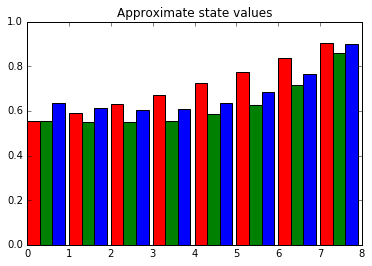

In [8]:
# Plot the results
fig, ax = plt.subplots()
width = 0.3

ax.bar(states, ls_avg, width, color='r')
ax.bar(states + width, td_avg, width, color='g')
ax.bar(states + 2*width, etd_avg, width, color='b')

# formatting 
ax.set_title('Approximate state values')
plt.show()

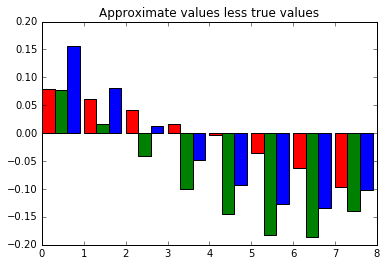

In [9]:
# Plot the results
fig, ax = plt.subplots()
width = 0.3

ax.bar(states, ls_avg - v_true, width, color='r')
ax.bar(states + width, td_avg - v_true, width, color='g')
ax.bar(states + 2*width, etd_avg - v_true, width, color='b')

# formatting 
ax.set_title('Approximate values less true values')
plt.show()

In [10]:
# Average over the values computed for each state
print("Least squares approximation error")
print(rmse(ls_avg, v_true, d_pi))

print("TD approximation error")
print(rmse(td_avg, v_true, d_pi))

print("ETD approximation error")
print(rmse(etd_avg, v_true, d_pi))

Least squares approximation error
0.020375153241
TD approximation error
0.0444149498921
ETD approximation error
0.0367492071662


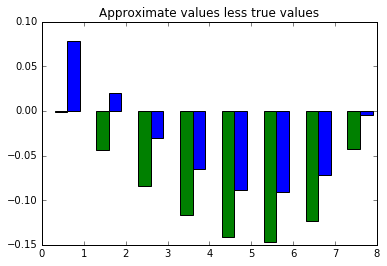

In [11]:
# Plot the results
fig, ax = plt.subplots()
width = 0.3

# ax.bar(states, ls_avg - v_true, width, color='r')
ax.bar(states + width, td_avg - ls_avg, width, color='g')
ax.bar(states + 2*width, etd_avg - ls_avg, width, color='b')

# formatting 
ax.set_title('Approximate values less true values')
plt.show()

In [12]:
print("RMS difference between TD and LS solution")
print(rmse(ls_avg, td_avg, d_pi))

print("RMS difference between ETD and LS solution")
print(rmse(ls_avg, etd_avg, d_pi))

RMS difference between TD and LS solution
0.0355938944627
RMS difference between ETD and LS solution
0.0226753265473


## Lambda=1.0

In [13]:
ns = 8
states = np.array([i for i in range(ns)])

# Target policy transition matrix
P_pi = np.diag(np.ones(ns-1), 1)
P_pi[-1,0] = 1

# Target policy distribution
d_pi = stationary(P_pi)

# Behavior policy transition matrix
P_mu = np.array([
        [0.0, 1, 0, 0, 0, 0, 0, 0],
        [0.0, 0, 1, 0, 0, 0, 0, 0],
        [0.0, 0, 0, 1, 0, 0, 0, 0],
        [0.0, 0, 0, 0, 1, 0, 0, 0],
        [0.5, 0, 0, 0, 0, 0.5, 0, 0],
        [0.5, 0, 0, 0, 0, 0, 0.5, 0],
        [0.5, 0, 0, 0, 0, 0, 0, 0.5],
        [1.0, 0, 0, 0, 0, 0, 0, 0],
], dtype=np.float)

# Behavior policy distribution
d_mu = stationary(P_mu)

# Reward vector under target policy
rvec = np.zeros(ns)
rvec[-1] = 1

# State-dependent parameters
gamma = 0.9*np.ones(ns)
gamma[0] = 0
lmbda = 1.0*np.ones(ns)
interest = np.ones(ns)

# True values
v_true = ls_solver(P_pi, rvec, np.eye(ns), gamma, d=d_pi)

In [14]:
num_trials = 5000
phi_length = 6
row_sum = 3

# Store the values
ls_lst = []
td_lst = []
etd_lst = []

for i in range(num_trials):
    print("Trial: %d"%i, end="\r")

    # Feature matrix
    X = random_binary(ns, phi_length, row_sum)

    # Least-squares solution
    w_ls = ls_solver(P_pi, rvec, X, gamma, d=d_pi)
    v_ls = np.copy(X @ w_ls)

    # TD solution
    w_td = td_solver(P_pi, rvec, X, gamma, lmbda, d=d_pi)
    v_td = np.copy(X @ w_td)

    # ETD solution
    w_etd = etd_solver(P_pi, rvec, X, gamma, lmbda, interest, d_pi=d_pi, d_mu=d_mu)
    v_etd = np.copy(X @ w_etd)
    
    # Store the data
    ls_lst.append(v_ls)
    td_lst.append(v_td)
    etd_lst.append(v_etd)

# Average the results
ls_avg = np.mean(ls_lst, axis=0)
td_avg = np.mean(td_lst, axis=0)
etd_avg = np.mean(etd_lst, axis=0)

# Average the errors
ls_errors = pd.Series([rmse(v_true, v, d_pi) for v in ls_lst])
td_errors = pd.Series([rmse(v_true, v, d_pi) for v in td_lst])
etd_errors = pd.Series([rmse(v_true, v, d_pi) for v in etd_lst])

# Describe the data
df = pd.DataFrame()
df['least-squares'] = ls_errors
df['TD'] = td_errors
df['ETD'] = etd_errors
df.describe()

,least-squares,TD,ETD
count,5000.000000,5000.000000,5000.000000
mean,0.032392,0.032392,0.039167
std,0.012978,0.012978,0.016792
min,0.000818,0.000818,0.000861
25%,0.022631,0.022631,0.025925
50%,0.032529,0.032529,0.039101
75%,0.042725,0.042725,0.052849
max,0.060025,0.060025,0.077641


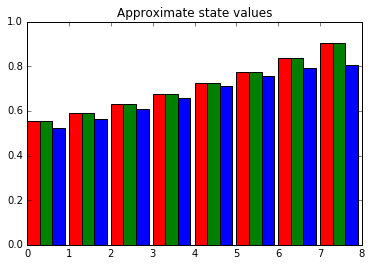

In [15]:
# Plot the results
fig, ax = plt.subplots()
width = 0.3

ax.bar(states, ls_avg, width, color='r')
ax.bar(states + width, td_avg, width, color='g')
ax.bar(states + 2*width, etd_avg, width, color='b')

# formatting 
ax.set_title('Approximate state values')
plt.show()

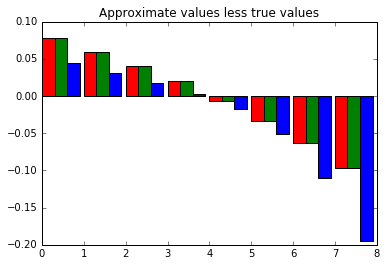

In [16]:
# Plot the results
fig, ax = plt.subplots()
width = 0.3

ax.bar(states, ls_avg - v_true, width, color='r')
ax.bar(states + width, td_avg - v_true, width, color='g')
ax.bar(states + 2*width, etd_avg - v_true, width, color='b')

# formatting 
ax.set_title('Approximate values less true values')
plt.show()

In [17]:
print("Least squares approximation error")
print(rmse(ls_avg, v_true, d_pi))

print("TD approximation error")
print(rmse(td_avg, v_true, d_pi))

print("ETD approximation error")
print(rmse(etd_avg, v_true, d_pi))

Least squares approximation error
0.0201701222401
TD approximation error
0.0201701222401
ETD approximation error
0.0295863810005


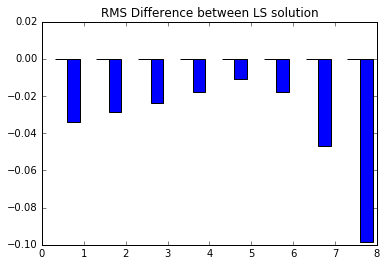

In [18]:
# Plot the results
fig, ax = plt.subplots()
width = 0.3

ax.bar(states + width, td_avg - ls_avg, width, color='g')
ax.bar(states + 2*width, etd_avg - ls_avg, width, color='b')

# formatting 
ax.set_title('RMS Difference between LS solution')
plt.show()

In [19]:
print("RMS difference between TD and LS solution")
print(rmse(ls_avg, td_avg, d_pi))

print("RMS difference between ETD and LS solution")
print(rmse(ls_avg, etd_avg, d_pi))

RMS difference between TD and LS solution
1.17756934401e-16
RMS difference between ETD and LS solution
0.0153947594717


### Commentary

- As expected, with lambda set to one, the solution found by TD is the same as the least squares solution.
- On average, emphasis TD seems to diverge from the least-squares solution most in the latter states.
    + These states are the ones that will tend to have the highest emphasis
    + Sometimes, it appears like the algorithm is trying to get those values right, since they are the ones it is emphasizing.
    + This case doesn't seem to be a correction-- when using the on-policy distribution, the difference disappears (as would be expected from following the derivation of ETD)
- I do not have a good intuition for why there is less discrepancy towards the "middle", that is, about half way between the start state and the "wall"

# Get name of notebook and export it, in a roundabout way

In [26]:
%%javascript
var attribs = document.body.attributes;
var cmd = "theNotebook = " + "'" + attribs['data-notebook-name'].value + "'";
IPython.notebook.kernel.execute(cmd);

<IPython.core.display.Javascript object>

In [27]:
%env __NOTEBOOK_NAME $theNotebook

env: __NOTEBOOK_NAME=chicken_solution.ipynb


In [28]:
%%bash
echo "ipython nbconvert --to html "$__NOTEBOOK_NAME""
ipython nbconvert --to html "$__NOTEBOOK_NAME"

ipython nbconvert --to html chicken_solution.ipynb


[NbConvertApp] Converting notebook chicken_solution.ipynb to html
[NbConvertApp] Writing 307723 bytes to chicken_solution.html
